## Práctica 1 - Detección de paneles de señalización vertical azul en autovías

Se desea construir un sistema para la detección automática de paneles informativos de tráfico de color azul, en imágenes realistas que han sido tomadas desde un coche (ver figura adjunta). Los paneles se han diseñado para que sean fácilmente distinguibles del entorno en cualquier condición de luz, color de fondo y climatología.

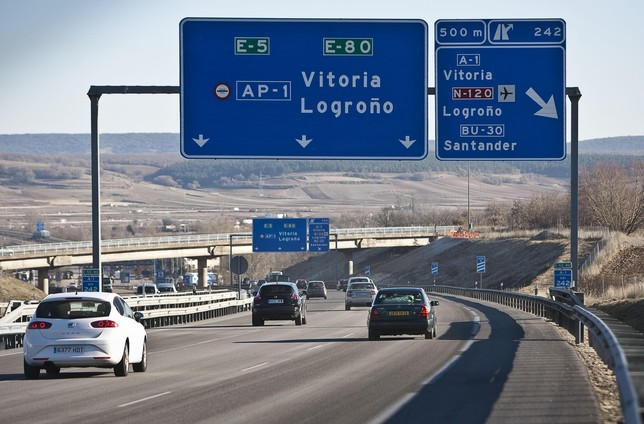

Observando la imagen adjunta podemos hacernos una idea sobre el tipo de información que nos permitirá distinguir un tipo de otro de panel, e incluso localizarlos en una imagen de carretera. En particular, se distinguen por su forma geométrica rectangular, por las zonas en las que se divide (borde claro y fondo oscuro) o por el color del mismo (azul y blanco). Es decir, para detectar este tipo de paneles podríamos utilizar:
- Un detector de regiones de alto contraste (detectaríamos la parte interna del panel).
- Un algoritmo que detectase rectángulos (p.ej., combinando detección de líneas con detectores de esquinas).
- Un algoritmo para descubrir qué píxeles son de color azul en la imagen junto con su distribución espacial.
- Detectar ciertas formas que aparecen en los paneles en localizaciones especiales (símbolo de salida de la autopista por la izquierda o derecha, diversos tipos de flechas, etc.).
- Cualquier otra técnica que tenga en cuenta color y forma.

El objetivo de esta práctica es desarrollar un detector básico de sub-paneles de información en autovías (como se ve en la figura adjunta). Hablamos de sub-paneles porque la idea es detectar cada una de las regiones rectangulares azules enmarcadas con un borde blanco en los paneles de la carretera. Para desarrollar el algoritmo de detección, como en muchos otros problemas de este tipo, se ofrece una
colección de imágenes de test tomadas desde un coche.

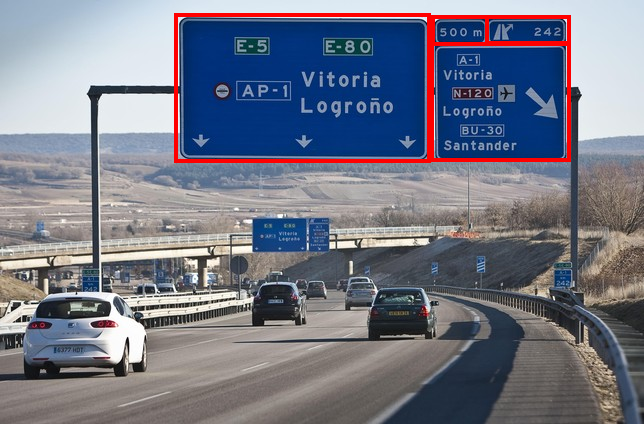

# Detección de regiones de alto contraste

Utilizar MSER como detector de regiones de alto contraste (mser.detectRegions). 

Cargar las imágenes de aprendizaje en color, guardarlas en una lista y mostrar la primera y la última usando imshow de matplotlib.

In [33]:
#Importamos bibliotecas que necesitaremos utilizar
import os
import random
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

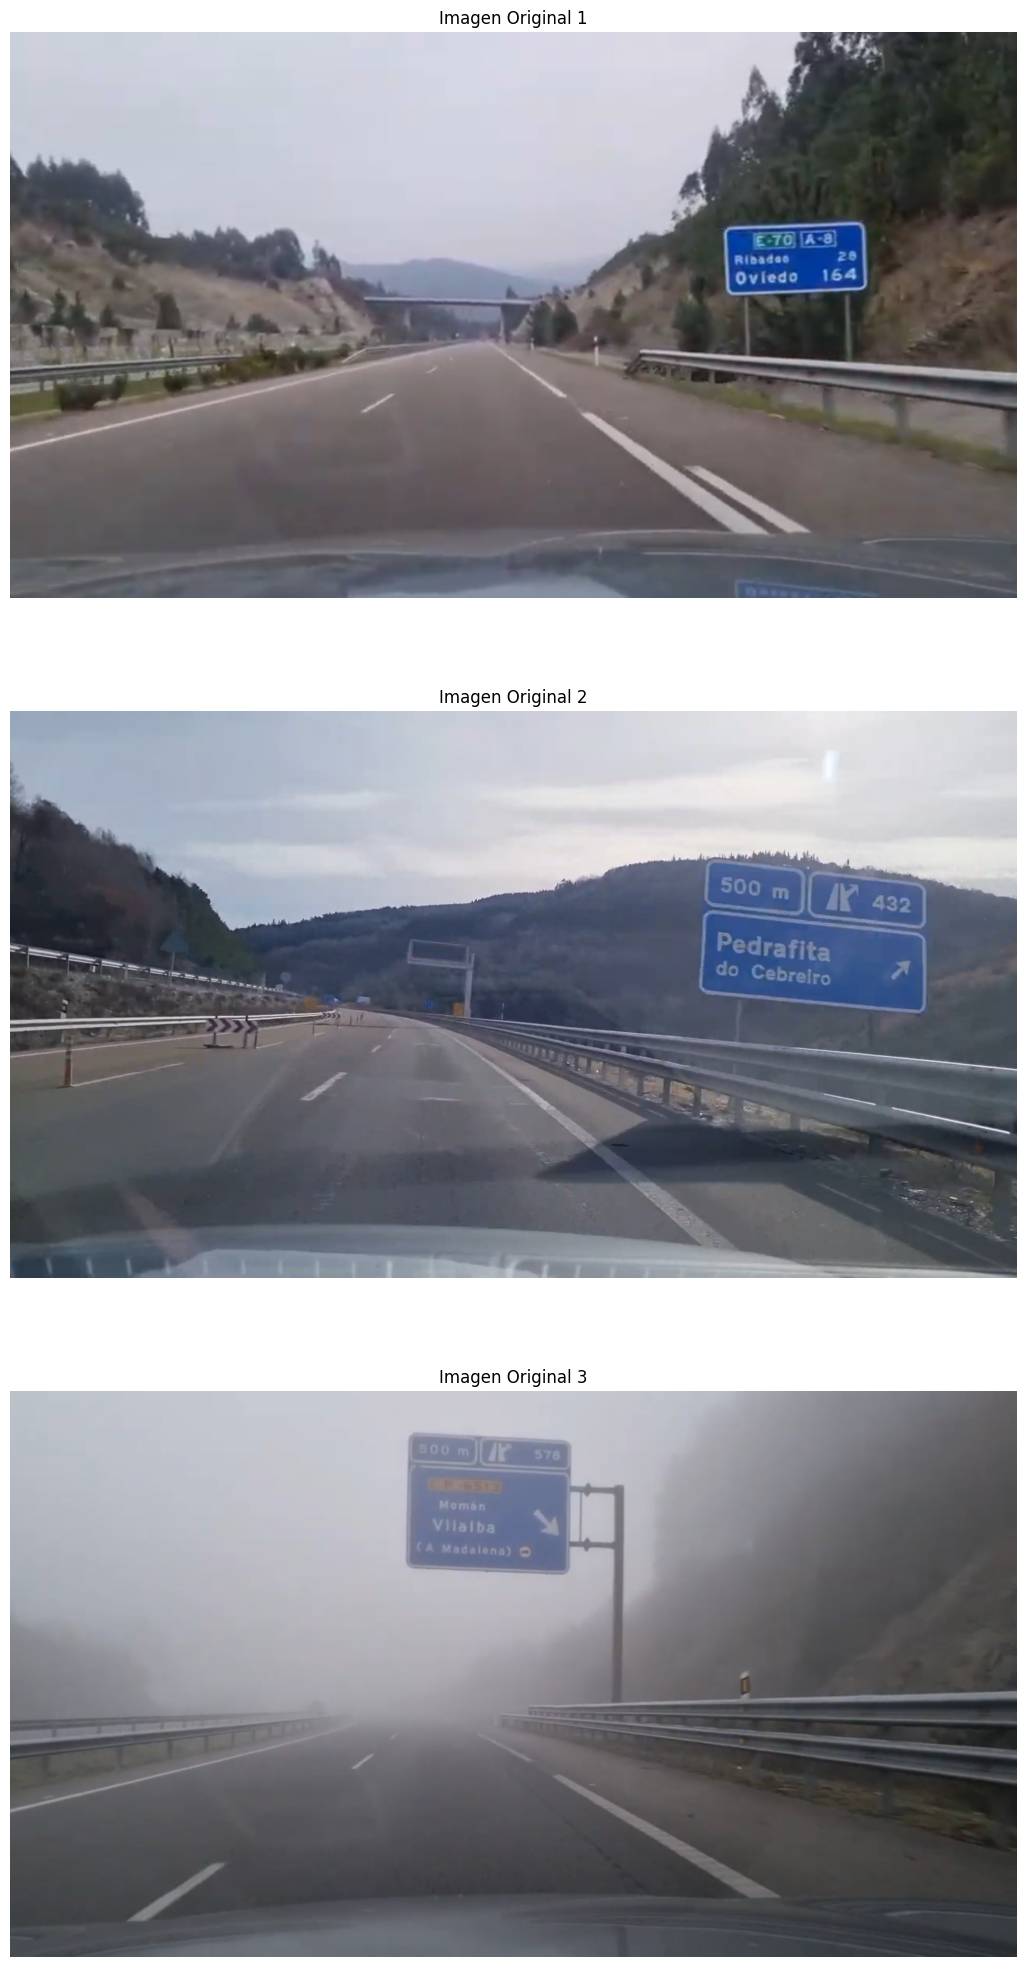

In [34]:
def CargaDeImagenes(directorio):
    imagenes = []
    for n in os.listdir(directorio):
        if n.endswith((".png")):
            img = cv2.imread(os.path.join(directorio,n))
            if img is not None:
                imagenes.append(img)
    return imagenes
# Variable para el numero de imagenes
tam = 3
# Obtiene el directorio de trabajo actual y construye la ruta al directorio de imágenes
directorio_ruta = os.path.join(os.getcwd(), 'imagenesTest')
carga_imagenes = CargaDeImagenes(directorio_ruta)
random_imagenes = random.sample(carga_imagenes,3)
#Por ahora mostraremos las imagenes que disponemos
# se cambiaria el dato de 3, para poder mostrar 101
fig, axes = plt.subplots(tam,1, figsize=(15,25))
for i in range(tam):
    axes[i].imshow(cv2.cvtColor(random_imagenes[i],cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Imagen Original {i+1}')
    axes[i].axis('off')

Pasar las imágenes cargadas a niveles de gris (y, posiblemente, mejorar su contraste con las técnicas vistas en clase). Mostrar la primera y la última usando imshow de matplotlib.

<function matplotlib.pyplot.show(close=None, block=None)>

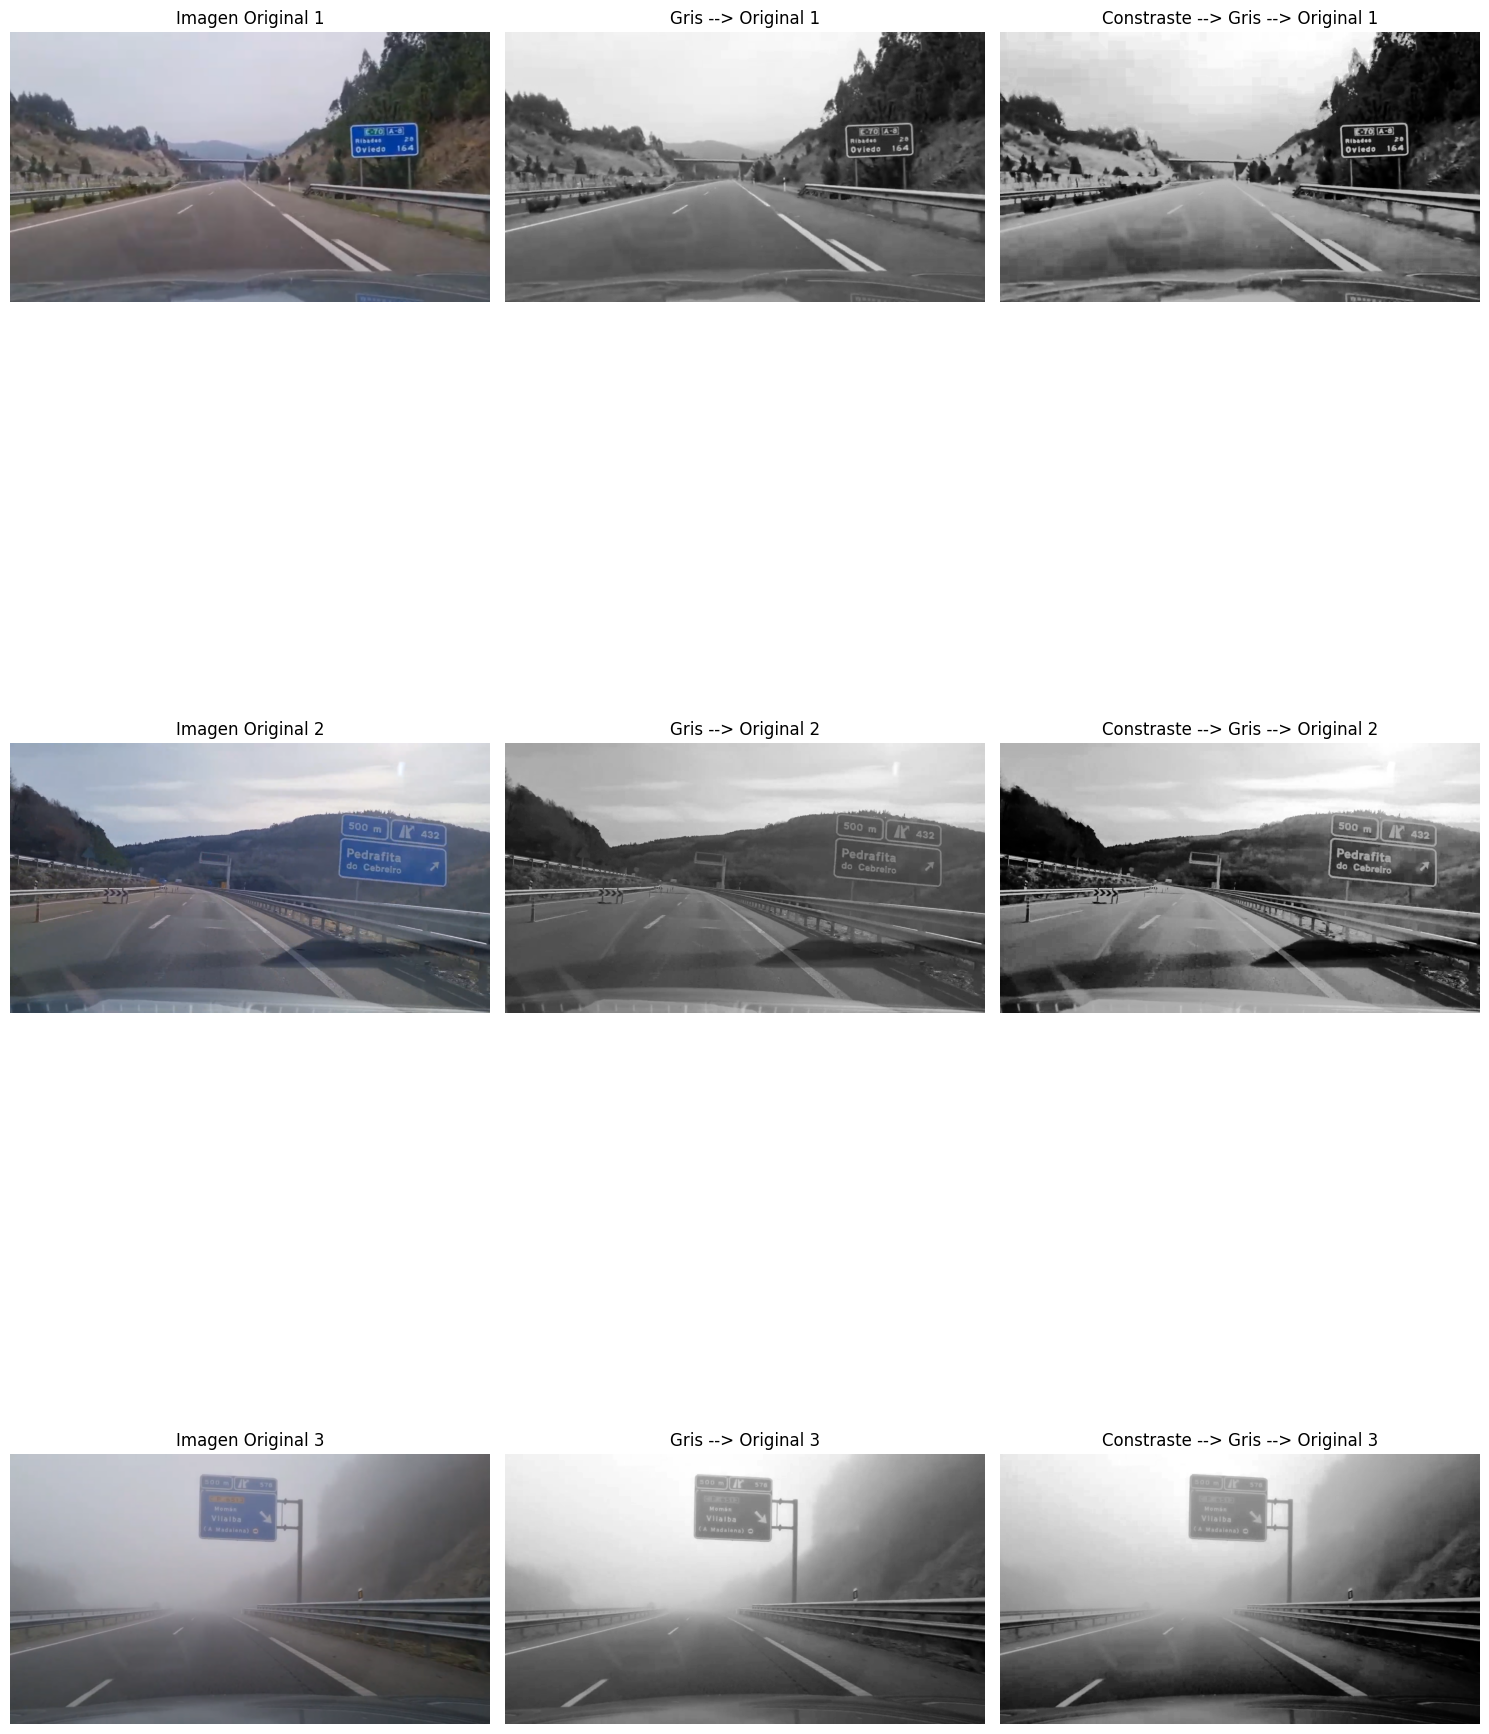

In [35]:
# Declaramos funcion para cargar las imagenes y convertirla a grises
def CargaImagenesGrises(lista_imagenes):
    imagenes = []
    grises = []
    for n in lista_imagenes:
        #img = cv2.imread(n, cv2.IMREAD_COLOR)
        imagenes.append(n)

        #Convertimos a grises
        imagen_gris = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)

        # kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        # imagen_gris = cv2.erode(imagen_gris, kernel)
        # Se pierde el contraste con las lineas blancas del recuadro de los paneles

        grises.append(imagen_gris)

        #Utilizamos un ecualizador para mejorar el contrasete
        contraste_imagen = cv2.equalizeHist(imagen_gris)
        grises.append(contraste_imagen)

    return imagenes, grises

# Llamamos a la función de grises
imagenes_color, imagenes_grises = CargaImagenesGrises(random_imagenes)

#Por ahora mostraremos las imagenes que disponemos
fig, axes = plt.subplots(tam,3, figsize=(15,25))
for i in range(tam):
    axes[i,0].imshow(cv2.cvtColor(imagenes_color[i],cv2.COLOR_BGR2RGB))
    axes[i,0].set_title(f'Imagen Original {i+1}')
    axes[i,0].axis('off')

    axes[i,1].imshow(imagenes_grises[2*i],cmap='gray')
    axes[i,1].set_title(f'Gris --> Original {i+1}')
    axes[i,1].axis('off')

    axes[i,2].imshow(imagenes_grises[2*i+1],cmap='gray')
    axes[i,2].set_title(f'Constraste --> Gris --> Original {i+1}')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show

Crear una función que aplique MSER a la lista de imágenes. Hay que tener en cuenta que los parámetros de MSER se pueden ajustar en el constructor de la clase (cv2.MSER_create). El ajustar los parámetros puede suponer eliminar muchas detecciones incorrectas (http://stackoverflow.com/questionshttps://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python/17647500/exact-meaning-of-the-parameters-given-to-initialize-mser-in-opencv-2-4-x).

Mostrar el resultado de aplicar la función sobre la primera y la última imagen de la lista usando imshow de matplotlib.

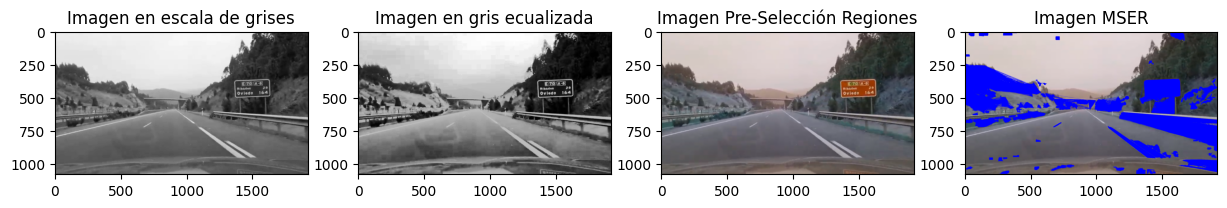

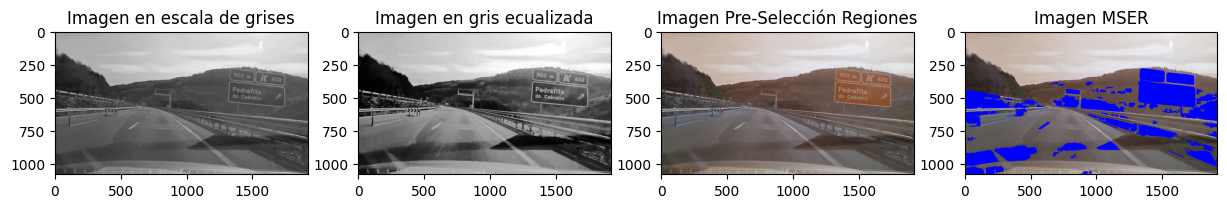

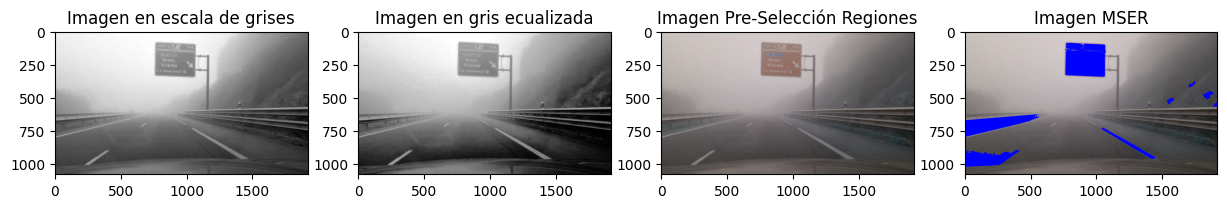

In [36]:
def aplicarMSER(imagenes):
  """
  Detecta regiones MSER en una lista de imágenes y las visualiza.

  Parámetros:
    imagenes: Lista de imágenes en formato BGR.

  Retorno:
    Lista de imágenes con las regiones MSER dibujadas.
  """

  mser = cv2.MSER_create()

  # Ajustar parámetros (opcional)
#   mser.setDelta(2)  # Reajusta el color verde (Mínimo de intensidades por pixeles)
#   mser.setMinArea(1000)  # Área mínima para que MSER considere la región
#   mser.setMaxArea(10000)  # Eliminar regiones muy grandes
#   mser.maxVariation(0.25)
#   mser.minDiversity(0.8)

  mser.setDelta(3)
  mser.setMinArea(400)
  mser.setMaxArea(60000) 
  mser.setMinDiversity(0.6)
  #mser.setPass2(True)

  resultados_mser = []

  for imagen in imagenes:
    # Convertir a escala de grises para MSER
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Ecualizar el histograma para mejorar el contraste
    gris_ecualizado = cv2.equalizeHist(gris)

    # Detectar regiones MSER en la Gris_Ecualizada
    regiones, _ = mser.detectRegions(gris_ecualizado)

    # Dibujar regiones en la imagen original
    imagen_mser = imagen.copy()

    # Extraer las regiones con la relación de aspecto deseada
    for region in regiones:
        x, y, w, h = cv2.boundingRect(region)

        relacion = round(h / w , 2)
        if relacion >= 0.3 and relacion <= 0.9:
          cv2.polylines(imagen_mser, [region], 1, (0, 0, 255))  

        

    # Mostrar imágenes (4 subplots)
    fig, axs = plt.subplots(1, 4, figsize=(15, 25))

    # Mostrar imagen en escala de grises
    axs[0].imshow(gris, cmap='gray')
    axs[0].set_title('Imagen en escala de grises')

    # Mostrar imagen en gris ecualizada
    axs[1].imshow(gris_ecualizado, cmap='gray')
    axs[1].set_title('Imagen en gris ecualizada')

    # Mostrar imagen original
    axs[2].imshow(imagen)
    axs[2].set_title('Imagen Pre-Selección Regiones')

    # Mostrar imagen MSER con regiones
    axs[3].imshow(imagen_mser)
    axs[3].set_title('Imagen MSER')

    

    plt.show()

    resultados_mser.append(imagen_mser)

  return resultados_mser

# Utilizamos la variable imagenes_color anterior
#https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
imagenes_mser = aplicarMSER(imagenes_color)



(-0.5, 1919.5, 1079.5, -0.5)

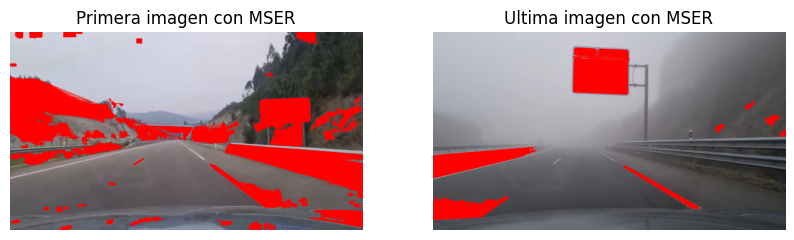

In [37]:
#Mostramos la primera y la última imagen de las regiones de MSER
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imagenes_mser[0], cv2.COLOR_BGR2RGB))
plt.title('Primera imagen con MSER')
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imagenes_mser[-1], cv2.COLOR_BGR2RGB))
plt.title('Ultima imagen con MSER')
plt.axis('off')

Crear una función que extraiga en un rectángulo los píxeles de la región detectada (cv2.boundingRect).

Mostrar gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en el paso anterior.

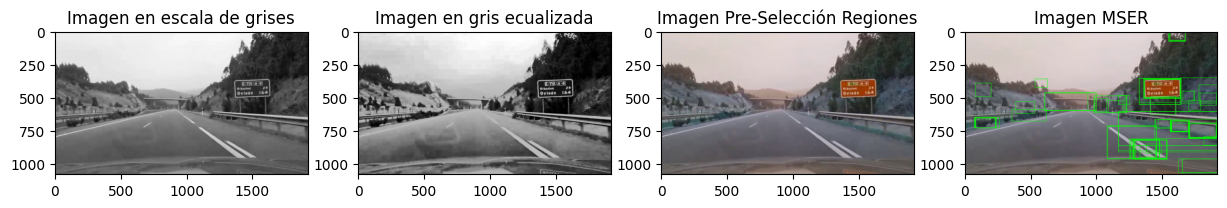

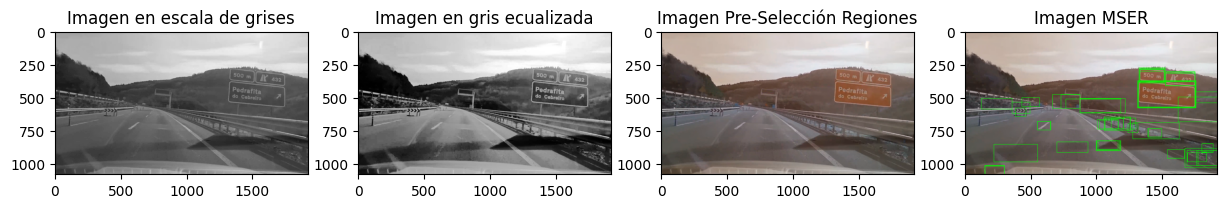

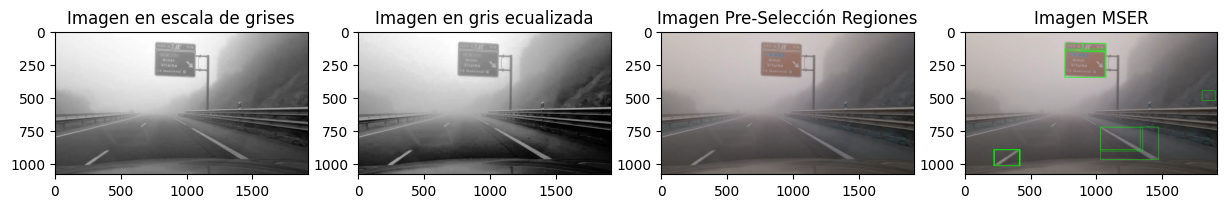

[array([[[217, 207, 201],
         [217, 207, 201],
         [217, 207, 201],
         ...,
         [ 50,  53,  51],
         [ 50,  53,  50],
         [ 49,  52,  50]],
 
        [[217, 207, 201],
         [217, 207, 201],
         [217, 207, 201],
         ...,
         [ 50,  53,  51],
         [ 50,  53,  50],
         [ 49,  52,  50]],
 
        [[217, 207, 201],
         [217, 207, 201],
         [217, 207, 201],
         ...,
         [ 50,  53,  51],
         [ 50,  53,  50],
         [ 49,  52,  50]],
 
        ...,
 
        [[ 94,  89,  88],
         [ 93,  89,  87],
         [ 93,  89,  87],
         ...,
         [ 83,  75,  69],
         [ 83,  75,  69],
         [ 83,  75,  69]],
 
        [[ 90,  85,  84],
         [ 90,  85,  83],
         [ 89,  85,  83],
         ...,
         [ 83,  75,  69],
         [ 83,  75,  69],
         [ 83,  75,  69]],
 
        [[ 88,  84,  82],
         [ 88,  84,  82],
         [ 88,  84,  82],
         ...,
         [ 83,  75,  69],
  

In [38]:
def aplicarMSER_agrandar(imagenes, margen):
  """
  Detecta regiones MSER en una lista de imágenes, las filtra por relación de aspecto y las agranda.

  Parámetros:
    imagenes: Lista de imágenes en formato BGR.
    margen: Valor de margen en píxeles para agrandar los rectángulos.

  Retorno:
    Lista de imágenes con las regiones MSER filtradas y agrandadas.
  """

  mser = cv2.MSER_create()

  # Ajustar parámetros (opcional)
  mser.setDelta(3)
  mser.setMinArea(400)
  mser.setMaxArea(60000) 
  mser.setMinDiversity(0.6)
  #mser.setPass2(True)

  resultados_mser = []

  for imagen in imagenes:
    # Convertir a escala de grises para MSER
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Ecualizar el histograma para mejorar el contraste
    gris_ecualizado = cv2.equalizeHist(gris)

    # Detectar regiones MSER en la Gris_Ecualizada
    regiones, _ = mser.detectRegions(gris_ecualizado)

    # Filtrar por relación de aspecto
    regiones_filtradas = []
    for region in regiones:
      x, y, w, h = cv2.boundingRect(region)
      relacion = round(h / w , 2)
      if relacion >= 0.3 and relacion <= 0.9 and x > 50 and  w > 20 and w < 800 and h > 50 and h < 900:
        regiones_filtradas.append(region)

    # Agrandar las regiones
    imagen_mser = imagen.copy()
    for region in regiones_filtradas:
      x, y, w, h = cv2.boundingRect(region)
      x1 = int(x - margen / 2)
      y1 = int(y - margen / 2)
      x2 = int(x + w + margen / 2)
      y2 = int(y + h + margen / 2)
      cv2.rectangle(imagen_mser, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Mostrar imágenes (4 subplots)
    fig, axs = plt.subplots(1, 4, figsize=(15, 25))

    # Mostrar imagen en escala de grises
    axs[0].imshow(gris, cmap='gray')
    axs[0].set_title('Imagen en escala de grises')

    # Mostrar imagen en gris ecualizada
    axs[1].imshow(gris_ecualizado, cmap='gray')
    axs[1].set_title('Imagen en gris ecualizada')

    # Mostrar imagen original
    axs[2].imshow(imagen)
    axs[2].set_title('Imagen Pre-Selección Regiones')

    # Mostrar imagen MSER con regiones
    axs[3].imshow(imagen_mser)
    axs[3].set_title('Imagen MSER')

    plt.show()

    resultados_mser.append(imagen_mser)

  return resultados_mser

aplicarMSER_agrandar(imagenes_color, 10)



Crear una función que elimine las regiones con una relación de aspecto (ancho/alto) muy diferente de la que tienen los sub-paneles. Si las regiones son demasiado alargadas en horizontal o vertical se podrán eliminar.

Mostrar gráficamente el resultado de aplicar la función sobre alguna imagen que rechace y sobre otra que acepte.

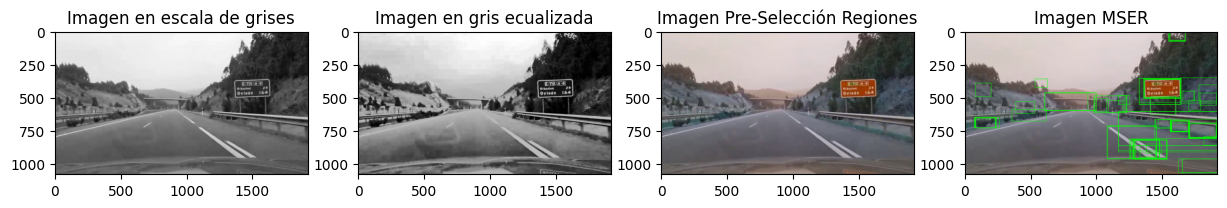

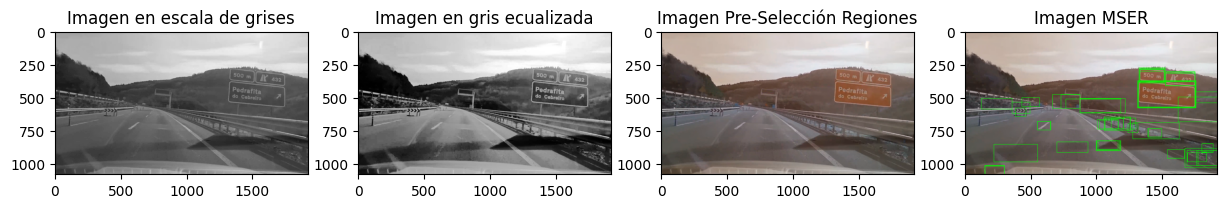

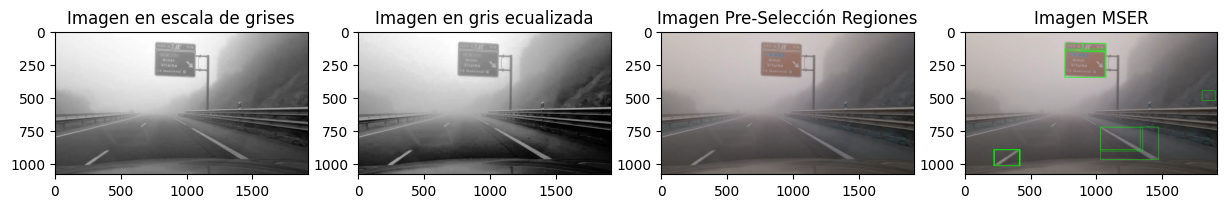

[array([[[217, 207, 201],
         [217, 207, 201],
         [217, 207, 201],
         ...,
         [ 50,  53,  51],
         [ 50,  53,  50],
         [ 49,  52,  50]],
 
        [[217, 207, 201],
         [217, 207, 201],
         [217, 207, 201],
         ...,
         [ 50,  53,  51],
         [ 50,  53,  50],
         [ 49,  52,  50]],
 
        [[217, 207, 201],
         [217, 207, 201],
         [217, 207, 201],
         ...,
         [ 50,  53,  51],
         [ 50,  53,  50],
         [ 49,  52,  50]],
 
        ...,
 
        [[ 94,  89,  88],
         [ 93,  89,  87],
         [ 93,  89,  87],
         ...,
         [ 83,  75,  69],
         [ 83,  75,  69],
         [ 83,  75,  69]],
 
        [[ 90,  85,  84],
         [ 90,  85,  83],
         [ 89,  85,  83],
         ...,
         [ 83,  75,  69],
         [ 83,  75,  69],
         [ 83,  75,  69]],
 
        [[ 88,  84,  82],
         [ 88,  84,  82],
         [ 88,  84,  82],
         ...,
         [ 83,  75,  69],
  

In [39]:
def aplicarMSER_agrandar(imagenes, margen):
  """
  Detecta regiones MSER en una lista de imágenes, las filtra por relación de aspecto y las agranda.

  Parámetros:
    imagenes: Lista de imágenes en formato BGR.
    margen: Valor de margen en píxeles para agrandar los rectángulos.

  Retorno:
    Lista de imágenes con las regiones MSER filtradas y agrandadas.
  """

  mser = cv2.MSER_create()

  # Ajustar parámetros (opcional)
  mser.setDelta(3)
  mser.setMinArea(400)
  mser.setMaxArea(60000) 
  mser.setMinDiversity(0.6)
  #mser.setPass2(True)

  resultados_mser = []

  for imagen in imagenes:
    # Convertir a escala de grises para MSER
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Ecualizar el histograma para mejorar el contraste
    gris_ecualizado = cv2.equalizeHist(gris)

    # Detectar regiones MSER en la Gris_Ecualizada
    regiones, _ = mser.detectRegions(gris_ecualizado)

    # Filtrar por relación de aspecto
    regiones_filtradas = []
    for region in regiones:
      x, y, w, h = cv2.boundingRect(region)
      relacion = round(h / w , 2)
      if relacion >= 0.3 and relacion <= 0.9 and x > 50 and  w > 20 and w < 800 and h > 50 and h < 900:
        regiones_filtradas.append(region)

    # Agrandar las regiones
    imagen_mser = imagen.copy()
    for region in regiones_filtradas:
      x, y, w, h = cv2.boundingRect(region)
      x1 = int(x - margen / 2)
      y1 = int(y - margen / 2)
      x2 = int(x + w + margen / 2)
      y2 = int(y + h + margen / 2)
      cv2.rectangle(imagen_mser, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Mostrar imágenes (4 subplots)
    fig, axs = plt.subplots(1, 4, figsize=(15, 25))

    # Mostrar imagen en escala de grises
    axs[0].imshow(gris, cmap='gray')
    axs[0].set_title('Imagen en escala de grises')

    # Mostrar imagen en gris ecualizada
    axs[1].imshow(gris_ecualizado, cmap='gray')
    axs[1].set_title('Imagen en gris ecualizada')

    # Mostrar imagen original
    axs[2].imshow(imagen)
    axs[2].set_title('Imagen Pre-Selección Regiones')

    # Mostrar imagen MSER con regiones
    axs[3].imshow(imagen_mser)
    axs[3].set_title('Imagen MSER')

    plt.show()

    resultados_mser.append(imagen_mser)

  return resultados_mser

aplicarMSER_agrandar(imagenes_color, 10)

En los sub-paneles, es posible que MSER haya detectado originalmente la región azul interna al borde blanco. Por tanto, es conveniente agrandar un poco el rectángulo detectado para que la imagen recortada contenga el sub-panel completo (incluyendo el borde blanco, y no sólo su parte interna). Si no se hace esto podemos tener una tasa de detección peor de la que realmente tenemos dado que las detecciones no solaparán completamente con las anotaciones.

Crear una función que agrande la zona y que muestre gráficamente el resultado de aplicar la función sobre la primera y la última imágenes devueltas en la celda de la función en MSER.

<Figure size 1200x400 with 0 Axes>

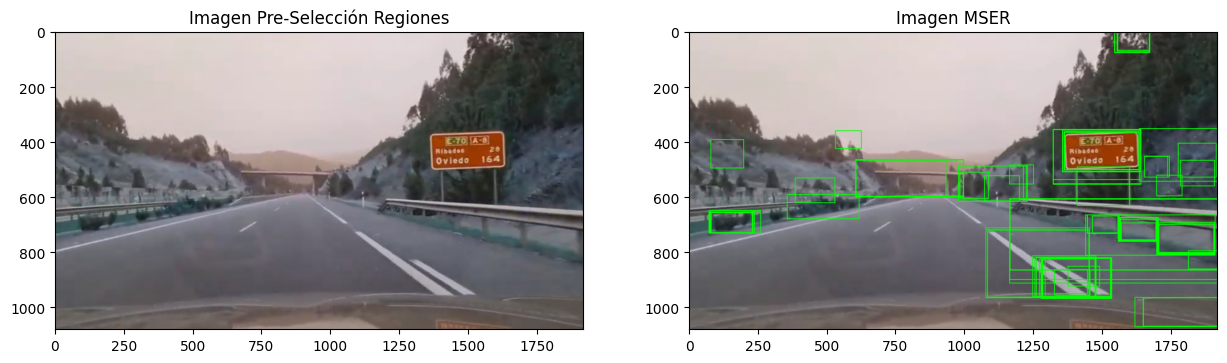

<Figure size 1200x400 with 0 Axes>

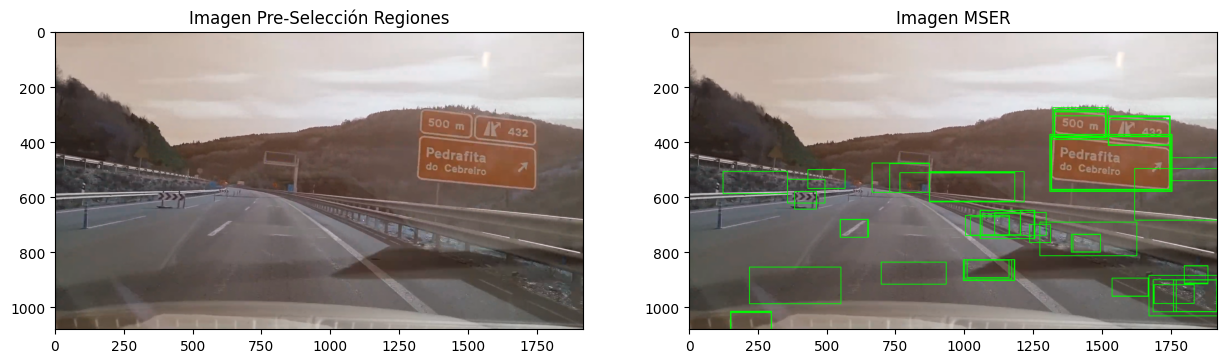

<Figure size 1200x400 with 0 Axes>

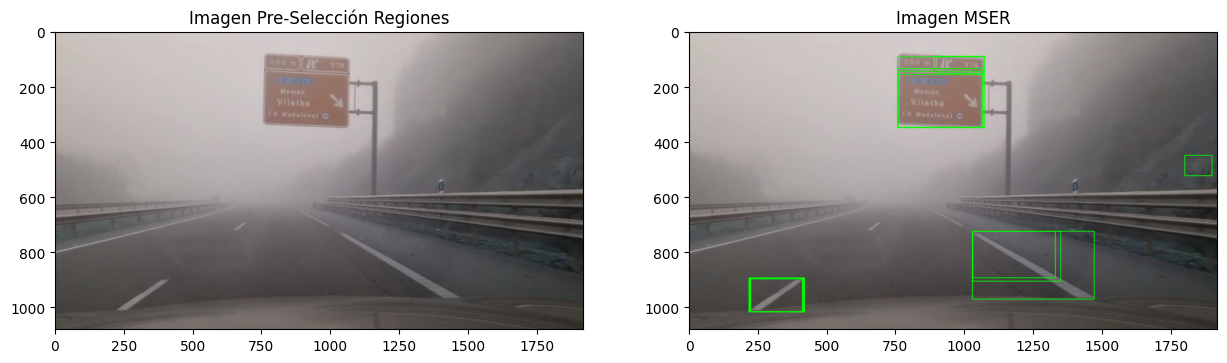

In [48]:
def aplicarMSER_agrandar(imagenes, margen):
  """
  Detecta regiones MSER en una lista de imágenes, las filtra por relación de aspecto y las agranda.

  Parámetros:
    imagenes: Lista de imágenes en formato BGR.
    margen: Valor de margen en píxeles para agrandar los rectángulos.

  Retorno:
    Lista de imágenes con las regiones MSER filtradas y agrandadas.
  """

  mser = cv2.MSER_create()

  # Ajustar parámetros (opcional)
  mser.setDelta(3)
  mser.setMinArea(400)
  mser.setMaxArea(60000) 
  mser.setMinDiversity(0.6)
  #mser.setPass2(True)

  resultados_mser = []

  for imagen in imagenes:
    # Convertir a escala de grises para MSER
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Ecualizar el histograma para mejorar el contraste
    gris_ecualizado = cv2.equalizeHist(gris)

    # Detectar regiones MSER en la Gris_Ecualizada
    regiones, _ = mser.detectRegions(gris_ecualizado)

    # Filtrar por relación de aspecto
    regiones_filtradas = []
    for region in regiones:
      x, y, w, h = cv2.boundingRect(region)
      relacion = round(h / w , 2)
      if relacion >= 0.3 and relacion <= 0.9 and x > 50 and  w > 20 and w < 800 and h > 50 and h < 900:
        regiones_filtradas.append(region)

    # Agrandar las regiones
    imagen_mser = imagen.copy()
    for region in regiones_filtradas:
      x, y, w, h = cv2.boundingRect(region)
      x1 = int(x - margen / 2)
      y1 = int(y - margen / 2)
      x2 = int(x + w + margen / 2)
      y2 = int(y + h + margen / 2)
      cv2.rectangle(imagen_mser, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    plt.figure(figsize=(12, 4))
    # Mostrar imágenes (4 subplots)
    fig, axs = plt.subplots(1, 2, figsize=(15, 25))

    # Mostrar imagen en escala de grises
    #axs[0].imshow(gris, cmap='gray')
    #axs[0].set_title('Imagen en escala de grises')

    # Mostrar imagen en gris ecualizada
    #axs[1].imshow(gris_ecualizado, cmap='gray')
    #axs[1].set_title('Imagen en gris ecualizada')

    # Mostrar imagen original
    axs[0].imshow(imagen)
    axs[0].set_title('Imagen Pre-Selección Regiones')

    # Mostrar imagen MSER con regiones
    axs[1].imshow(imagen_mser)
    axs[1].set_title('Imagen MSER')

    plt.show()

    resultados_mser.append(imagen_mser)

  return resultados_mser

imagenes_mser = aplicarMSER_agrandar(imagenes_color, 10)

## Detección mediante correlación de máscaras

En esta sección se desea utilizar el espacio de color HSV para localizar los píxeles que sean del color azul (característico del panel) y que estén muy saturados (tiene que ser un azul bastante puro). 

Para ello, en primer lugar se necesita construir una máscara ideal. Por ejemplo un np.array de tamaño fijo (p.ej. 40x80) en el que los píxeles azules y muy saturados tengan valor 1, y 0 el resto. Esta matriz será la máscara de color azul saturado del sub-panel informativo general. La máscara indicaría en qué píxeles debería tener color azul saturado el subpanel.

Mostrar gráficamente la máscara ideal usando imshow.

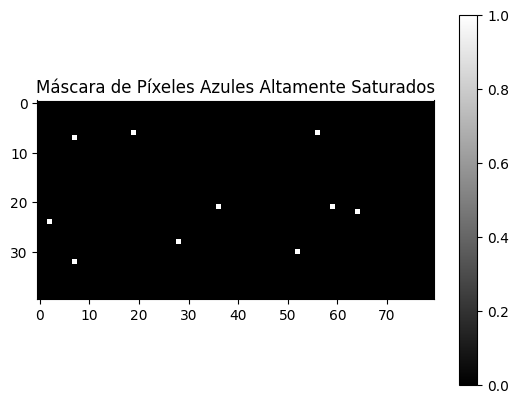

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un arreglo de 40x80 inicializado en cero
mask = np.zeros((40, 80), dtype=int)

hue_min, hue_max = 110/2, 130/2  # El rango de matiz en OpenCV es 0-180 para imágenes, por lo que los 360 grados se reducen a la mitad
sat_min, value_min = 204, 204  # en escalas de 255

# Generar aleatoriamente algunos píxeles 'azules' para demostración
# En la práctica, verificarías los valores de píxel de una imagen
np.random.seed(0)
indices_azules = np.random.choice(np.arange(mask.size), size=10, replace=False)
mask.ravel()[indices_azules] = 1  # Establecer los píxeles azules a 1

# Visualizar la máscara
plt.imshow(mask, cmap='grey')
plt.title('Máscara de Píxeles Azules Altamente Saturados')
plt.colorbar()
plt.show()

Crear una función que recorte cada ventana detectada por MSER en una imagen y devuelva una lista de imágenes con un tamaño fijo (p.ej. 40x80 píxeles) usando cv2.resize.

Mostrar gráficamente el resultado de aplicar dicha función sobre una imagen que tenga varios paneles.

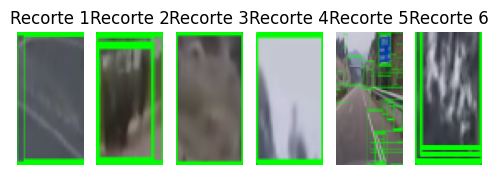

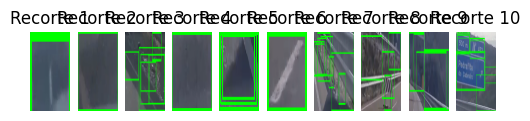

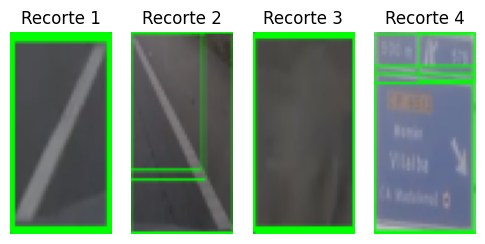

'\ntodos_los_recortes_nitidos = []\nfor recortes in recortes_redimensionados:\n    recortes_nitidos = [aplicar_filtro_nitidez(recorte) for recorte in recortes]\n    todos_los_recortes_nitidos.append(recortes_nitidos)\n    mostrar_recortes(recortes_nitidos)\n    '

In [76]:
def recortar_y_redimensionar_region(imagenes_mser, tamano_fijo=(40, 80)):
    recortes_redimensionados = []
    for imagen_mser in imagenes_mser:
        # Detectar contornos en la imagen basado en el color de marcado de las regiones (verde aquí)
        contours, _ = cv2.findContours(cv2.inRange(imagen_mser, (0, 255, 0), (0, 255, 0)), 
                                       cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        recortes = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            recorte = imagen_mser[y:y+h, x:x+w]
            recorte_redimensionado = cv2.resize(recorte, tamano_fijo, interpolation=cv2.INTER_AREA)
            recortes.append(recorte_redimensionado)
        recortes_redimensionados.append(recortes)

    return recortes_redimensionados

def mostrar_recortes(recortes):
    plt.figure(figsize=(6, 12))
    for i, recorte in enumerate(recortes):
        plt.subplot(1, len(recortes), i+1)
        plt.imshow(cv2.cvtColor(recorte, cv2.COLOR_BGR2RGB))
        plt.title(f'Recorte {i+1}')
        plt.axis('off')
    plt.show()

def aplicar_filtro_nitidez(imagen):
    # Utilizar un kernel de nitidez
    kernel_sharpening = np.array([[-1, -1, -1], 
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    imagen_nitida = cv2.filter2D(imagen, -1, kernel_sharpening)
    return imagen_nitida

# Uso de la función
recortes_redimensionados = recortar_y_redimensionar_region(imagenes_mser)

for recortes in recortes_redimensionados:
    mostrar_recortes(recortes)
'''
todos_los_recortes_nitidos = []
for recortes in recortes_redimensionados:
    recortes_nitidos = [aplicar_filtro_nitidez(recorte) for recorte in recortes]
    todos_los_recortes_nitidos.append(recortes_nitidos)
    mostrar_recortes(recortes_nitidos)
    '''


Crear una función que extraiga los píxeles de color azul saturado (que llamaremos M) de la ventana redimensionada.

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior.

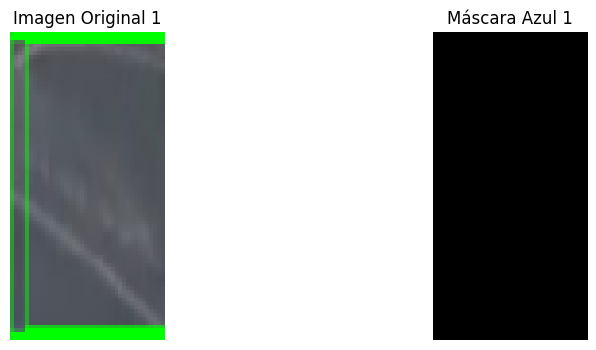

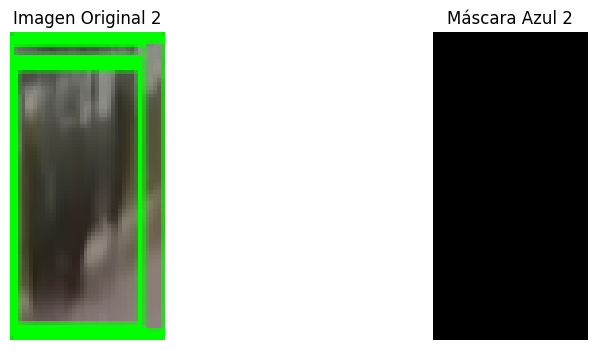

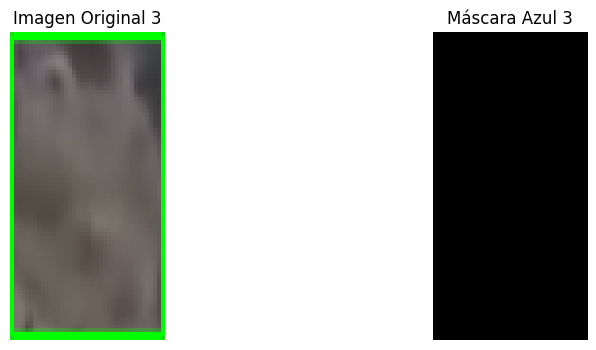

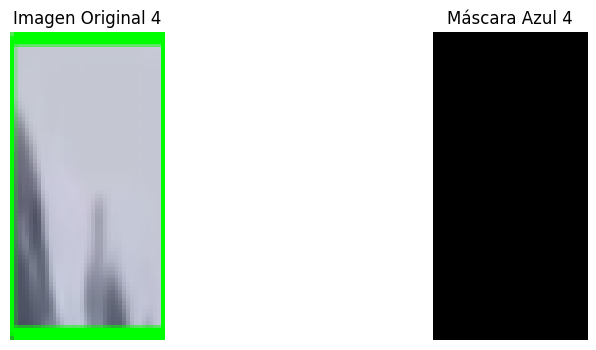

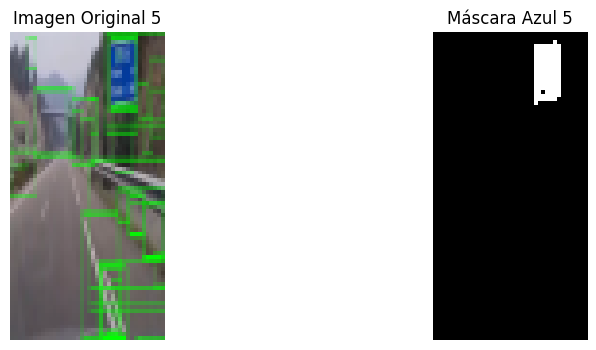

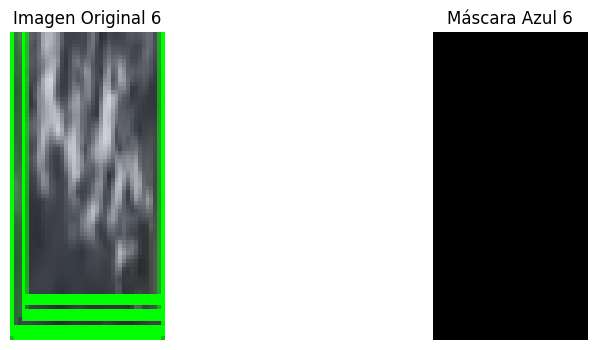

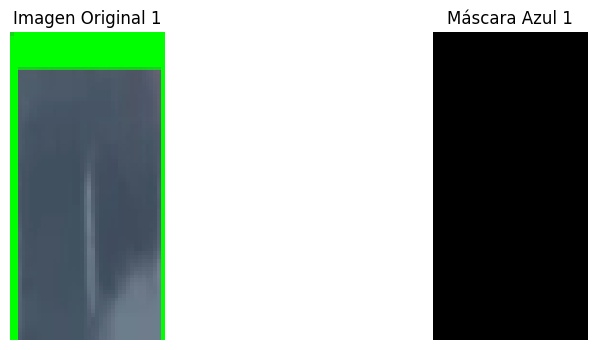

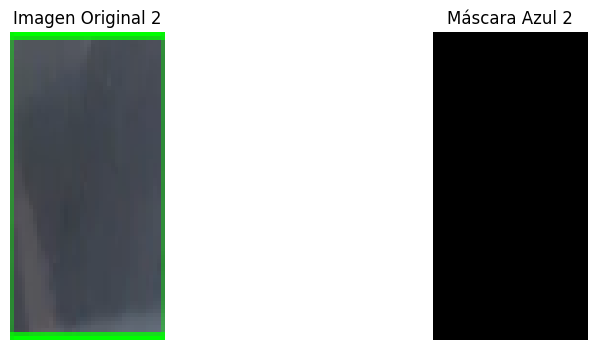

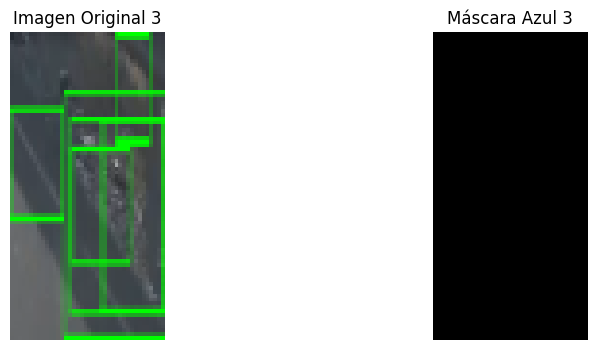

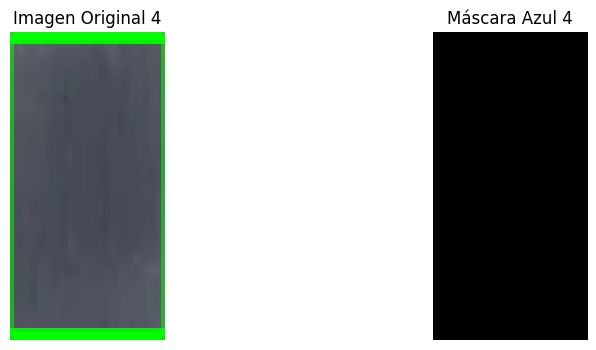

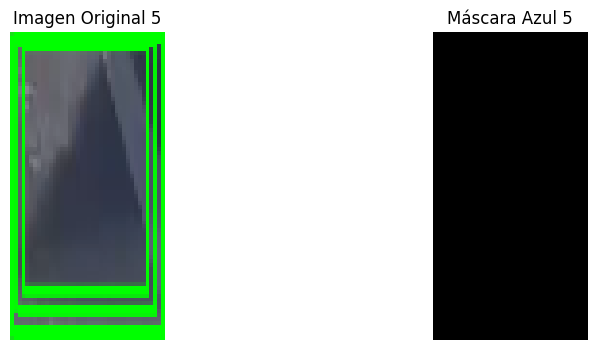

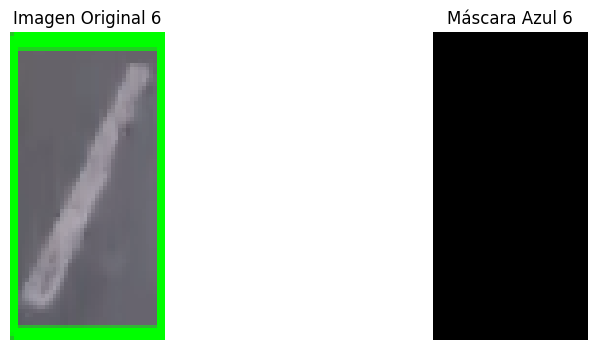

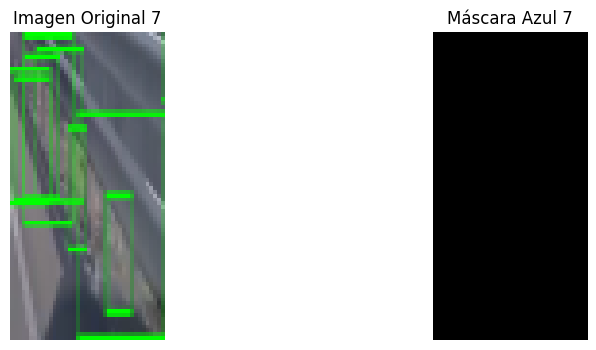

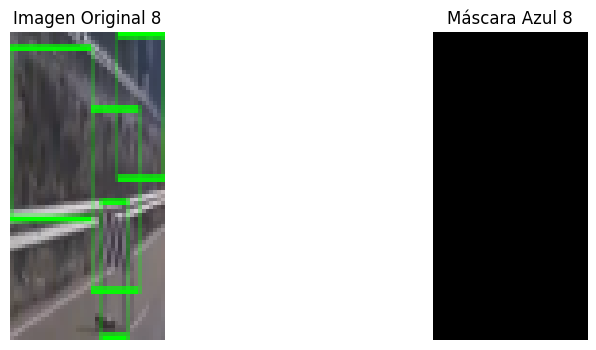

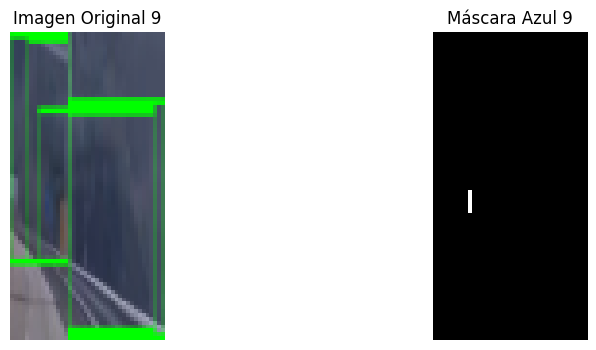

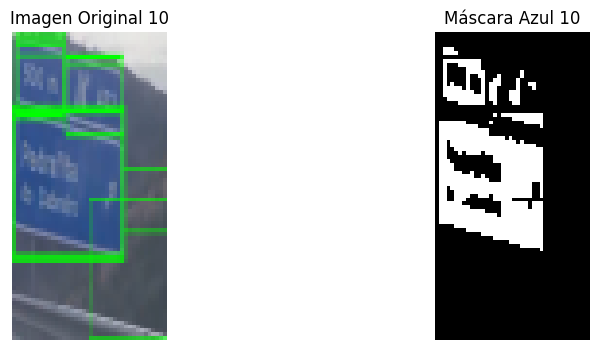

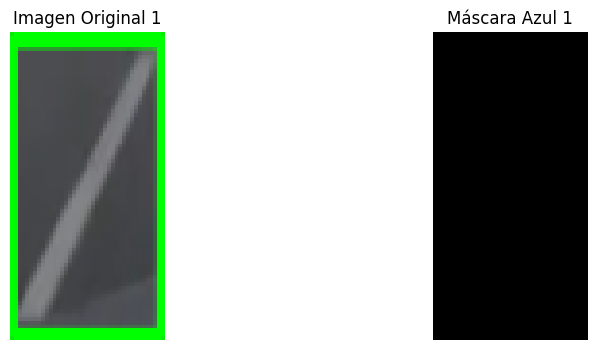

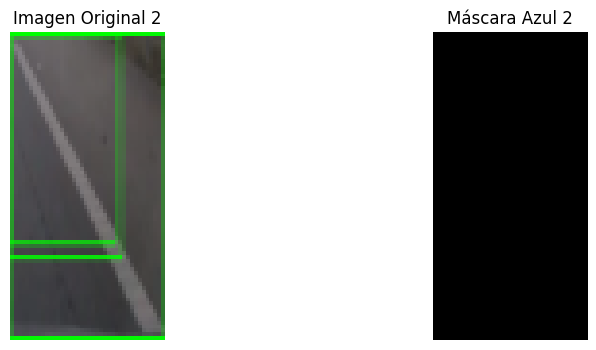

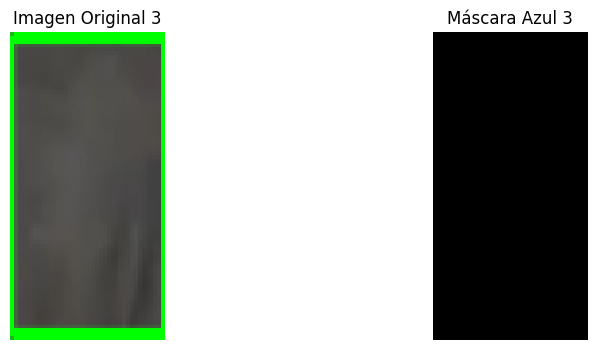

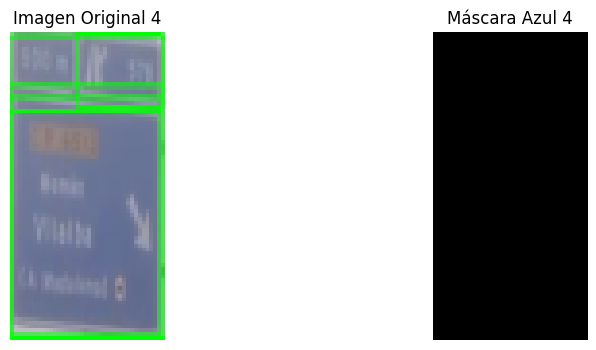

In [77]:
def extraer_azul_saturado(imagen):
    
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Definir rangos para el color azul en el espacio HSV
    azul_bajo = np.array([80, 125, 60])  # Hue de 200-260, Saturación y Valor altos
    azul_alto = np.array([140, 255, 255])
    
    # Crear una máscara que extraiga píxeles dentro del rango azul
    mascara_azul = cv2.inRange(hsv, azul_bajo, azul_alto)
    
    return mascara_azul

def mostrar_mascara_azul(imagenes):
    
    for i, img in enumerate(imagenes):
        mascara = extraer_azul_saturado(img)
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Imagen Original {i+1}')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mascara, cmap='gray')
        plt.title(f'Máscara Azul {i+1}')
        plt.axis('off')
        
        plt.show()

for recortes in recortes_redimensionados:
    mostrar_mascara_azul(recortes)

Crear una función que correle M (multiplicar elemento a elemento y sumar), con la máscara de color azul saturado ideal que debería tener un sub-panel de carretera (p.ej. casi todos los píxeles a 1). Se puede
usar el valor de correlación para saber cuál es la proporción de píxeles de color azul saturado en el sub-panel evaluado. 

Mostrar gráficamente el resultado de aplicar dicha función sobre los paneles detectados en la celda anterior y que muestre también el valor numérico de dicha correlación.

Si se pone un umbral también se pueden rechazar ventanas como “no panel” cuando tienen una correlación muy baja (es decir, las que “tienen poco azul”).

Si al correlar se supera el umbral, establecer el valor de correlación como la puntuación, o score, que daremos a esa ventana detectada. Ello nos indicará “cómo de parecido es lo detectado a un sub-panel” esa parte de la imagen (0 no es sub-panel y 1 sí lo es).

Establecer un umbral que permita rechazar algunas imágenes que realmente habría que rechazar y que acepte algunas imágenes que debería aceptar.

Mostrar gráficamente algunas imágenes, los valores de correlación obtenidos y el resultado de aplicar el umbral.

## Eliminación de detecciones repetidas

MSER detecta la parte interna del sub-panel (p.ej. la parte azul dentro del borde blanco) varias veces dependiendo de los parámetros que le pasemos y además la parte externa (el borde), con lo que muy probablemente tendremos más de una detección correspondiente a cada sub-panel. En esta parte de la práctica se pide diseñar un algoritmo para la que las ventanas repetidas se queden reducidas a una sola detección. Este algoritmo puede utilizar alguna de las siguientes ideas:
- Definir un criterio de solapamiento de ventanas (p.ej. el área de la intersección dividido por el área de la unión de dos ventanas).
- Elegir la ventana que contenga a otras de las que se solapen.
- Elegir la ventana promedio de las que solapen.
- Otros criterios propuestos por los alumnos.

Crear una función filtre los resultados de MSER y mostrar los resultados de aplicar dicha función sobre algunos ejemplos donde tenga impacto.

## Evaluación de los resultados de detección

Seleccionar un subconjunto de, al menos, 20 imágenes del conjunto de imágenes de test proporcionado. Estas imágenes deben de ser lo suficientemente representativas como para contener todas las variabilidades presentes en el dataset de imágenes (p.ej., diferentes condiciones meteorológicas, diferentes tamaños y perspectivas de los sub-paneles en las escenas, etc). 

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

Para las 20 imágenes de test seleccionadas, pintar (por ejemplo, en color rojo), los rectángulos donde se han detectado los sub-paneles en cada una de las imágenes consideradas.

Mostrar gráficamente dichas imágenes en una matriz de tamaño suficiente usando la función subplot de matplotlib.

Mostrar resultados cuantitativos de detección usando la métrica de IoU (Intersection over Union)

## Normalización de las imágenes de los paneles detectados

Muchos paneles detectados en las imágenes pueden aparecer ligeramente rotados (debido al efecto de la perspectiva) y/o también afectados por unas condiciones de iluminación desfavorable. Ello puede  dificultar el posterior reconocimiento de la información contenida en los mismos. La Figura adjunta ilustra un ejemplo de esta situación.

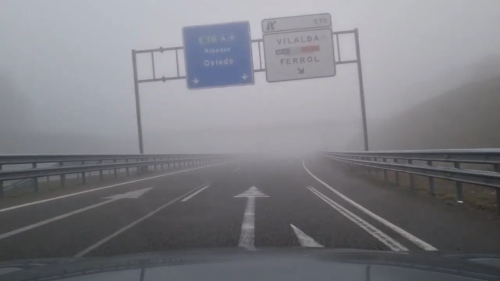

En este apartado se pide desarrollar una función que aplique las normalizaciones que se consideren con respecto a la posición del cartel en la imagen y/o la corrección del efecto de la iluminación.

Mostrar gráficamente el resultado de aplicar dicha normalización sobre un conjunto de imágenes que lo requieran.